**混合图像 Hybrid Image**

@wc

- $\bf{Step1:}$定义高斯卷积核$G_{\sigma}$, 读入图像
- $\bf{Step2:}$编写ConvFunction,分别对Image1和Image2的每个通道做滤波, 得到低通图像
- $\bf{Step3:}$用第一幅低通图像$+$第二幅图的高通图像

<span style="color: blue;">**Step I**</span>

In [28]:
import numpy as np
from PIL import Image

dog_image = PIL.Image.open("dog.jpg")#读入dog.jpg
cat_image = PIL.Image.open("cat.jpg")#读入cat.jpg


dog_image_array = np.array(dog_image)#转为三通道矩阵
cat_image_array = np.array(cat_image)

print("Dog image size:",str(dog_image_array.shape))#(height, weight, channels)
print("Cat image size:",str(dog_image_array.shape))


Dog image size: (361, 410, 3)
Cat image size: (361, 410, 3)


Gaussian kernel: $$\bf{G_{\sigma}=\frac{1}{2\pi\sigma^2}e^{-\frac{(x^2+y^2)}{2\sigma^2}}}$$

In [21]:
def GausVal (sigma, x, y):
    return 1 / (2 * np.pi * sigma**2)*np.exp(-((x**2 + y**2) / (2 * sigma**2)))
print("Value of posision (0,0) is ",str(GausVal(5,0,0)))

Value of posision (0,0) is  0.006366197723675813


[[3.54326422e-07 4.71169822e-07 6.20309523e-07 ... 4.71169822e-07
  3.54326422e-07 2.63807214e-07]
 [4.71169822e-07 6.26543738e-07 8.24864050e-07 ... 6.26543738e-07
  4.71169822e-07 3.50800815e-07]
 [6.20309523e-07 8.24864050e-07 1.08595882e-06 ... 8.24864050e-07
  6.20309523e-07 4.61840034e-07]
 ...
 [4.71169822e-07 6.26543738e-07 8.24864050e-07 ... 6.26543738e-07
  4.71169822e-07 3.50800815e-07]
 [3.54326422e-07 4.71169822e-07 6.20309523e-07 ... 4.71169822e-07
  3.54326422e-07 2.63807214e-07]
 [2.63807214e-07 3.50800815e-07 4.61840034e-07 ... 3.50800815e-07
  2.63807214e-07 1.96412803e-07]]


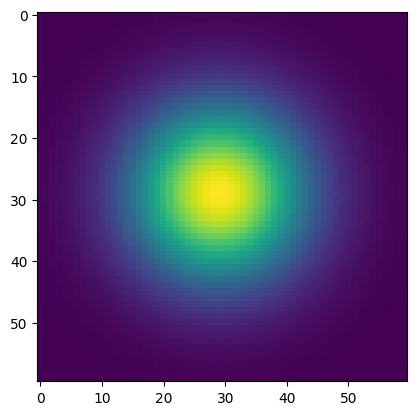

In [71]:
import matplotlib.pyplot as plt
def GausKernel_init (sigma):
    GausKernel = np.zeros((6*sigma,6*sigma))
    for x in range(-3*sigma,3*sigma+1):
        for y in range(-3*sigma,3*sigma+1):
            GausKernel[3*sigma-y-1,3*sigma+x-1] = GausVal(sigma, x, y)#建立起xy坐标系和矩阵索引之间的关系
    return GausKernel
print(GausKernel_init(10))
plt.imshow(GausKernel_init(10))

<span style="color: blue;">**Step II**</span>

ConvFuncion: $$\mathbf{H}\ast \mathbf{F}=\sum_{u=-k}^{k}\sum_{v=-k}^{k}\mathbf{H}[u,v]\mathbf{F}[i-u,j-v]$$

$$Padding = \lfloor (kernelsize-1)/2 \rfloor$$

In [67]:
"""
多通道padding
"""
def AddPadding(image,kernel):
    padding = (kernel.shape[0]-1)//2
    image_padding = np.zeros((image.shape[0]+2*padding,image.shape[1]+2*padding,image.shape[2]))#初始化大小
    for k in range(image.shape[2]):
        for i in range(padding,padding+image.shape[0]):
            for j in range(padding,padding+image.shape[1]):
                image_padding[i,j,k] = image[i-padding,j-padding,k]
    return image_padding
iimage = Image.fromarray(AddPadding(dog_image_array,GausKernel_init(10)).astype('uint8'), 'RGB')
cimage = Image.fromarray(AddPadding(cat_image_array,GausKernel_init(10)).astype('uint8'), 'RGB')
iimage.save('dog_padding_10.png')
cimage.save('cat_padding_10.png')

加入**padding**之后的dog图像（$\sigma=10$）：

![Alt text](dog_padding_10-1.png)

![Alt text](cat_padding_10-1.png)

编写卷积函数ConvFunc (Gaussian kernel呈中心对称)

In [65]:
dog_padding = AddPadding(dog_image_array,GausKernel_init(10))
cat_padding = AddPadding(cat_image_array,GausKernel_init(10))
print("加入padding之后的图像大小为:",str(dog_padding.shape))
print("sigma=5时的卷积核大小为:",str(GausKernel_init(5).shape))
def ConvFunc(image_padding, image_size, kernel):
    res = np.zeros(image_size)
    for channel in range(image_padding.shape[2]):
        for col in range(image_padding.shape[1] - kernel.shape[1] + 1):#防止宽度越界
            for row in range(image_padding.shape[0] - kernel.shape[0] + 1):#防止长度越界
                res[row, col, channel] = np.sum(image_padding[row:row+kernel.shape[0], col:col+kernel.shape[1], channel] * kernel)
    return res
dog_res = ConvFunc(dog_padding,dog_image_array.shape,GausKernel_init(10)) 
cat_res = ConvFunc(cat_padding,cat_image_array.shape,GausKernel_init(10))
print("卷积后大小为:",str(dog_res.shape))
dog_low_pass = Image.fromarray(dog_res.astype('uint8'), 'RGB')#低通图像
cat_low_pass = Image.fromarray(cat_res.astype('uint8'), 'RGB')
dog_low_pass.save('dog_low_pass.png')
cat_low_pass.save('cat_low_pass.png')

加入padding之后的图像大小为: (419, 468, 3)
sigma=5时的卷积核大小为: (30, 30)
卷积后大小为: (361, 410, 3)


***高斯滤波后的 cat and dog***

![Alt text](cat_low_pass-1.png)

![Alt text](dog_low_pass-1.png)

<span style="color: blue;">**Step III**</span>

In [69]:
cat_high_pass = cat_image_array-cat_res
high_pass = Image.fromarray(cat_high_pass.astype('uint8'), 'RGB')
high_pass.save('high_pass_cat.png')

***猫的高通图像***

![Alt text](high_pass_cat-1.png)

In [70]:
hybrid_image = cat_high_pass + dog_res
hybrid_image_res = Image.fromarray(hybrid_image.astype('uint8'), 'RGB')
hybrid_image_res.save('Hybrid image.png')

***混合图像 Hybrid Image***

![Alt text](<Hybrid image-1.png>)